# Analysis of gene expression data

# I Data Retrieval
Data Retrieval was done using the RScript!

- Download Data (Thyroid cancer data)  


In [1]:
from pyunpack import Archive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy import stats
import statsmodels.stats.multitest as mt

from tqdm import tqdm
import networkx as nx

In [2]:
'''
genes_C_id=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_genes_C.txt",header=None)
genes_C_id.columns=['gene']
genes_N_id=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_genes_N.txt",header=None)
genes_N_id.columns=['gene']  
'''
patients_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_C.txt",header=None)
patients_C.columns=['patients']
patients_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_N.txt",header=None)
patients_N.columns=['patients']

genes_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_C.txt",sep=' ')
genes_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_N.txt",sep=' ')


clinical_data=pd.read_csv("TCGA-UCEC/TCGA-UCEC_clinical_data.txt")

In [3]:
print(patients_C.shape[0],'  --------> patients with cancer')
print(patients_N.shape[0],'  --------> patients without cancer')

551   --------> patients with cancer
35   --------> patients without cancer


In [7]:
print('Number of genes available -------->',len(set(genes_C.index).intersection(set(genes_N.index))))

Number of genes available --------> 56512


In [8]:
##Select only patients for whom cancer and normal tissue files are available.
patients_C_N=(set(patients_C.patients).intersection(set(patients_N.patients))) # consider 23 patients
print('Number of patients for whom cancer and normal tissue files are available -------->', len(patients_C_N))

patients_C_N

Number of patients for whom cancer and normal tissue files are available --------> 23


{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [9]:
genes_N_T = genes_N.T 
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])
genes_N_T['patient'] = patients_lst

genes_N_T.set_index('patient',drop=True,inplace=True)

genes_N = genes_N_T[genes_N_T.index.isin(patients_C_N)].T

In [10]:
genes_C_T = genes_C.T 
genes_C_T['patient'] = list(genes_C_T.index)

patients_lst = genes_C_T.patient.apply(lambda x: x[:12])
genes_C_T['patient'] = patients_lst

genes_C_T.set_index('patient',drop=True,inplace=True)

genes_C = genes_C_T[genes_C_T.index.isin(patients_C_N)].T

genes_N_T = genes_N.T #[:12]
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])
genes_N_T['patient'] = patients_lst

genes_N = genes_N_T[genes_N_T.patient.isin(patients_C_N)].T
genes_N.drop('patient',inplace=True)
genes_N

genes_N_T = genes_N.T #[:12]
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])
genes_N_T['patient'] = patients_lst

genes_N = genes_N_T[genes_N_T.patient.isin(patients_C_N)].T
genes_N.drop('patient',inplace=True)
genes_N.columns=list(patients_lst)

genes_C_T = genes_C.T #[:12]
genes_C_T['patient'] = list(genes_C_T.index)

patients_lst = genes_C_T.patient.apply(lambda x: x[:12])
genes_C_T['patient'] = patients_lst
genes_C = genes_C_T[genes_C_T.patient.isin(patients_C_N)].T
genes_C.drop('patient',inplace=True)
genes_C.columns=patients_lst

genes_C_T = genes_C.T #[:12]
genes_C_T['patient'] = list(genes_C_T.index)

patients_lst = genes_C_T.patient.apply(lambda x: x[:12])
 
genes_C.columns=patients_lst



genes_N_T = genes_N.T #[:12]
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])

genes_N.columns=list(patients_lst)

In [11]:
set(genes_C.index==genes_N.index) #check of order of genes is the same in both dataframes

{True}

In [12]:
print(genes_C.shape)
print(genes_N.shape)

(56512, 23)
(56512, 23)


In [13]:
genes_CN=genes_C.join(genes_N,lsuffix='_caller', rsuffix='_other',how='inner') #BOTH C and N

# II  Identify Differentially expressed genes

 

2. Identify Differentially Expressed Genes (DEGs) specifying the thresholds setting. Select the thresholds to obtain a subset of hundreds of genes: p-value should be less than or equal to 0.05 (it is suggested to apply a correction for multiple comparisons) and Fold Change greater than or equal to 1.2.


## Which genes are differentially expressed?


**Fold Change**
A first criterion can be to identify the genes whose expression in the two
groups of samples considered varies by a certain proportion (doubles,
halves, ...)

𝑓𝑜𝑙𝑑𝑐ℎ𝑎𝑛𝑔𝑒=$𝑙𝑜𝑔_2\frac{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑1}{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑2}$=2


Condition 1 - Normal

Condition 2 - Cancer

In [14]:
fold_df=np.abs(np.log2(genes_C.mean(axis=1)/genes_N.mean(axis=1)))
fold_df[fold_df>=2]#1.2 was not enough to reach subset of 500 combined with p-value 0.01 and correction

C:\Users\dusic\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ENSG00000000005    2.679112
ENSG00000002726    4.444725
ENSG00000003249    2.793129
ENSG00000003436    3.158650
ENSG00000004776    3.752695
                     ...   
ENSG00000281852    4.747679
ENSG00000281856         inf
ENSG00000281863         inf
ENSG00000281880    2.195136
ENSG00000281887         inf
Length: 12136, dtype: float64

In [15]:
fold_sort_df=pd.DataFrame(fold_df[fold_df>=3.2])
fold_sort_df.columns=['fold_value']


#drop nan and inf(when log is not defined--> log0)
fold_sort_df.dropna(inplace=True)
fold_sort_df=fold_sort_df[(fold_sort_df.fold_value!=np.inf)]
fold_sort_df.sort_values(['fold_value'],ascending=False)

,fold_value
ENSG00000164816,12.356761
ENSG00000125363,10.224694
ENSG00000107187,9.992548
ENSG00000258808,9.927897
ENSG00000215853,9.750622
...,...
ENSG00000253373,3.202486
ENSG00000228824,3.202412
ENSG00000265962,3.201967
ENSG00000111241,3.200606


## Statistical tests
## Student’s t test for two conditions/groups (control vs treated)

In [16]:
fold_sort_df.index #USE JUST THESE GENES which have fold value >=1.2

Index(['ENSG00000002726', 'ENSG00000004776', 'ENSG00000004799',
       'ENSG00000006118', 'ENSG00000006377', 'ENSG00000007908',
       'ENSG00000007968', 'ENSG00000008196', 'ENSG00000009709',
       'ENSG00000011426',
       ...
       'ENSG00000280916', 'ENSG00000280953', 'ENSG00000281128',
       'ENSG00000281131', 'ENSG00000281186', 'ENSG00000281392',
       'ENSG00000281732', 'ENSG00000281809', 'ENSG00000281832',
       'ENSG00000281852'],
      dtype='object', length=2554)

In [17]:
genes_C_reduced=genes_C[genes_C.index.isin(fold_sort_df.index)]
genes_N_reduced=genes_N[genes_N.index.isin(fold_sort_df.index)]

Because of the fold change we reduced # of DEG 

In [18]:
print('From ',genes_C.shape[0],'to ------->',genes_C_reduced.shape[0],' in the Primary solid Tumor data')
print('From ',genes_N.shape[0],'to ------->',genes_N_reduced.shape[0],' in the Solid Tissue Normal data')

From  56512 to -------> 2554  in the Primary solid Tumor data
From  56512 to -------> 2554  in the Solid Tissue Normal data


### Performing t-tests for each gene for both conditions 

In [19]:
stat_lst=[]
pvalue_lst=[]
ttest_df=pd.DataFrame(columns=['gene','statistic','pvalue'])
for i in tqdm(range(genes_C_reduced.shape[0])):# FOR ALL
    res=stats.ttest_ind(genes_C_reduced.iloc[i,:],genes_N_reduced.iloc[i,:])
    stat_lst.append(res[0])
    pvalue_lst.append(res[1])
    ttest_df=ttest_df.append({'gene':genes_C_reduced.index[i],'statistic':res[0],'pvalue':res[1]},ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2554/2554 [00:13<00:00, 185.78it/s]


In [20]:
ttest_df[ttest_df.pvalue<0.01]

,gene,statistic,pvalue
1,ENSG00000004776,-6.413717,8.309865e-08
2,ENSG00000004799,-4.390986,6.988086e-05
3,ENSG00000006118,7.434610,2.650385e-09
4,ENSG00000006377,5.937346,4.171373e-07
6,ENSG00000007968,6.258298,1.407119e-07
...,...,...,...
2548,ENSG00000281186,-2.907786,5.684178e-03
2549,ENSG00000281392,-9.808681,1.208123e-12
2550,ENSG00000281732,-2.853833,6.561883e-03
2552,ENSG00000281832,-2.749166,8.634294e-03


In [21]:
# HOW many? DEG pairs
ttest_df[ttest_df.pvalue<0.01].shape[0]

1165

Correction method for p-values used:
        
        • FDR (False Discovery Rate): check if the k th ordered p value is larger
          than (k × a)/N  --->Benjamini/Hochberg (non-negative)
          


In [22]:
corr=mt.multipletests(ttest_df.pvalue, alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False) 
#fdr_bh : Benjamini/Hochberg (non-negative)

In [23]:
corr[0]

array([False,  True,  True, ..., False, False,  True])

In [24]:
after_correction=ttest_df[corr[0]]
after_correction.shape[0]

966

In [25]:
after_correction[after_correction.pvalue<0.01]

,gene,statistic,pvalue
1,ENSG00000004776,-6.413717,8.309865e-08
2,ENSG00000004799,-4.390986,6.988086e-05
3,ENSG00000006118,7.434610,2.650385e-09
4,ENSG00000006377,5.937346,4.171373e-07
6,ENSG00000007968,6.258298,1.407119e-07
...,...,...,...
2534,ENSG00000280339,-7.951202,4.740807e-10
2538,ENSG00000280429,-3.347998,1.675761e-03
2545,ENSG00000280953,3.098478,3.384255e-03
2549,ENSG00000281392,-9.808681,1.208123e-12


In [26]:
after_correction.gene[after_correction.gene.index[:2]].values

array(['ENSG00000004776', 'ENSG00000004799'], dtype=object)

In [27]:
#example of 3 DEG in normal and cancer tissue sample
def plotGenes(example_genes):
    plt.figure(figsize=(20,10)) 
    for idx,ex in enumerate(example_genes):
        tissue_C = genes_C_reduced[genes_C_reduced.index==example_genes[idx]].values.tolist()[0]
        tissue_N = genes_N_reduced[genes_N_reduced.index==example_genes[idx]].values.tolist()[0]

        plt.plot(range(1,len(tissue_C)+1),tissue_C)


    plt.legend(example_genes)
    plt.axvline(5, linewidth=800,  color = 'r',alpha=0.05)
    plt.axvline(400, linewidth=800,  color = 'b',alpha=0.05)
    plt.show()

In [28]:
res_df=fold_sort_df.join(after_correction.set_index('gene'),lsuffix='_caller', rsuffix='_other',how='inner')
res_df=res_df.sort_values(['pvalue'],ascending=True).sort_values(['fold_value'],ascending=False)
res_df.head(1)

,fold_value,statistic,pvalue
ENSG00000258808,9.927897,-5.239168,0.000004


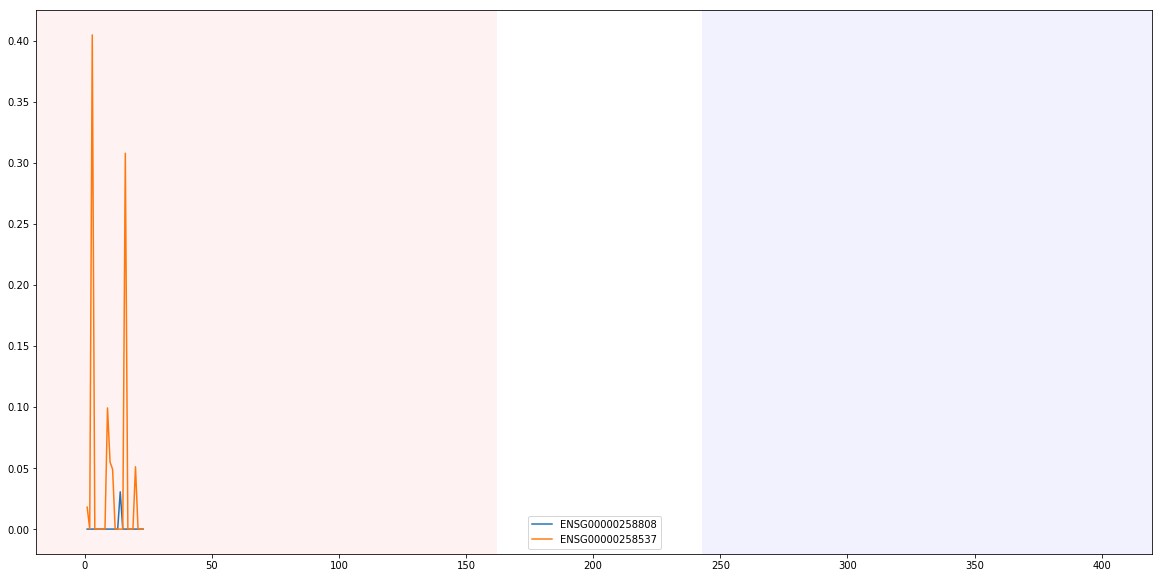

In [29]:
DEG_examples=list(res_df.index[[0,7]])
plotGenes(DEG_examples)

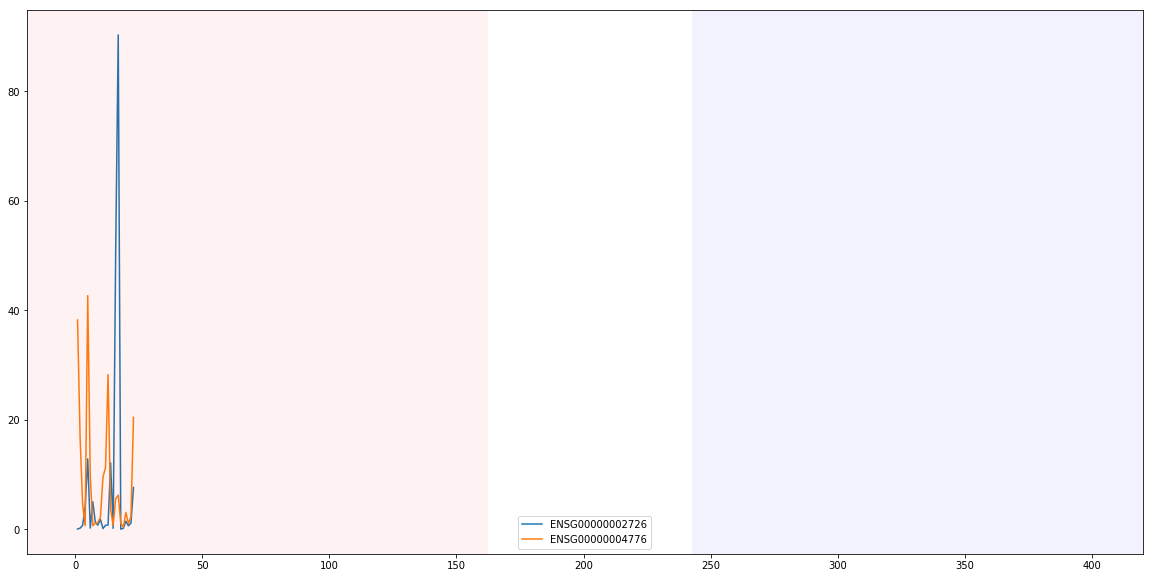

In [30]:
NONDEG_examples=list(fold_sort_df[fold_sort_df<0.2].index)[:2]
plotGenes(NONDEG_examples)

# III Gene co-expression 
 

## Which and how many genes are co expressed?

3. Using only DEGs, compute the gene co-expression networks related to the 2 conditions (cancer, normal) considering:
        o Pearson’s correlation;
        o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [31]:
chosen_genes_C=genes_C[genes_C.index.isin(after_correction.gene.values)]
chosen_genes_N=genes_N[genes_N.index.isin(after_correction.gene.values)]

In [32]:
set(chosen_genes_N.columns).intersection(chosen_genes_C.columns)

{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [33]:
all_chosen=chosen_genes_C.T.append(chosen_genes_N.T)#chosen_genes_C.append(chosen_genes_N)
all_chosen.shape

(46, 966)

In [34]:
all_chosen=all_chosen.apply(lambda x: x.astype('float64'))
all_chosen.shape

(46, 966)

In [35]:
corr_matrix=all_chosen.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix

In [36]:
corr_matrix #diagonal needs to have zeros and 1 if Pearson correlation coefficient is > 0.7

,ENSG00000004776,ENSG00000004799,ENSG00000006118,ENSG00000006377,ENSG00000007968,ENSG00000011426,ENSG00000011465,ENSG00000012124,ENSG00000013810,ENSG00000022267,...,ENSG00000280200,ENSG00000280285,ENSG00000280304,ENSG00000280319,ENSG00000280323,ENSG00000280339,ENSG00000280429,ENSG00000280953,ENSG00000281392,ENSG00000281852
ENSG00000004776,1.000000,0.503265,0.520489,0.478603,0.491644,0.531603,0.596036,0.514546,0.545181,0.574409,...,0.433596,0.466449,0.820624,0.166709,0.408328,0.750639,0.562809,0.279904,0.596578,0.764009
ENSG00000004799,0.503265,1.000000,0.439086,0.393295,0.385787,0.416551,0.802150,0.238555,0.452695,0.562896,...,0.267514,0.212304,0.743450,0.013997,0.158119,0.758184,0.230731,0.254383,0.672506,0.478022
ENSG00000006118,0.520489,0.439086,1.000000,0.641670,0.448073,0.532663,0.491643,0.338342,0.493155,0.532867,...,0.355516,0.337238,0.535765,0.322763,0.329068,0.585757,0.348236,0.300839,0.599911,0.552322
ENSG00000006377,0.478603,0.393295,0.641670,1.000000,0.698441,0.700763,0.444252,0.323937,0.516829,0.478999,...,0.302273,0.328638,0.484752,0.293238,0.300782,0.538526,0.328277,0.265683,0.559482,0.477371
ENSG00000007968,0.491644,0.385787,0.448073,0.698441,1.000000,0.727305,0.467117,0.308937,0.747273,0.503036,...,0.321656,0.354505,0.524635,0.297063,0.297399,0.544007,0.315169,0.083597,0.619560,0.486138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000280339,0.750639,0.758184,0.585757,0.538526,0.544007,0.599325,0.920618,0.426504,0.617950,0.729339,...,0.433238,0.306741,0.880330,0.170209,0.302808,1.000000,0.422757,0.341466,0.737619,0.606214
ENSG00000280429,0.562809,0.230731,0.348236,0.328277,0.315169,0.373668,0.277200,0.169500,0.372882,0.418937,...,0.018481,0.674499,0.482003,0.033312,0.566352,0.422757,1.000000,0.194995,0.355766,0.402946
ENSG00000280953,0.279904,0.254383,0.300839,0.265683,0.083597,0.140539,0.281897,0.191490,0.270593,0.303986,...,0.173804,0.185103,0.297994,0.115262,0.177323,0.341466,0.194995,1.000000,0.351955,0.321086
ENSG00000281392,0.596578,0.672506,0.599911,0.559482,0.619560,0.650308,0.655371,0.489225,0.642970,0.600391,...,0.324854,0.407718,0.811955,0.339670,0.315106,0.737619,0.355766,0.351955,1.000000,0.653065


In [38]:
def adj_method(x):
    if x>0.7:
        return 1
    else:
        return 0

In [39]:
## o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [40]:
adj_matrix=corr_matrix.copy()
np.fill_diagonal(adj_matrix.values, 0)

for col in adj_matrix.columns:
    adj_matrix[col]=adj_matrix[col].apply(adj_method)

In [45]:
def corrAndAdj(data):
    corr_matrix=data.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix
    adj_matrix=corr_matrix.copy()
    np.fill_diagonal(adj_matrix.values, 0)
    def adj_method(x):
        if x>0.7:
            return 1
        else:
            return 0
    adj_matrix=corr_matrix.copy()
    for col in adj_matrix.columns:
        adj_matrix[col]=adj_matrix[col].apply(adj_method)
    return corr_matrix,adj_matrix

In [85]:
corr_matrix_N,adj_matrix_N = corrAndAdj(chosen_genes_N)
corr_matrix_C,adj_matrix_C = corrAndAdj(chosen_genes_C)

In [62]:
>>> G = nx.from_pandas_adjacency(adj_matrix)
>>> G.name = 'Graph from pandas adjacency matrix'
>>> print(nx.info(G))

Name: Graph from pandas adjacency matrix
Type: Graph
Number of nodes: 966
Number of edges: 38967
Average degree:  80.6770


In [87]:
def show_graph_with_labels(adjacency_matrix):
    plt.figure(figsize=(20,25)) 
    mylabels={}
    for idx,val in enumerate(adjacency_matrix.index):
           mylabels[idx]=val
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=2, labels=mylabels, with_labels=True)
    plt.show()

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


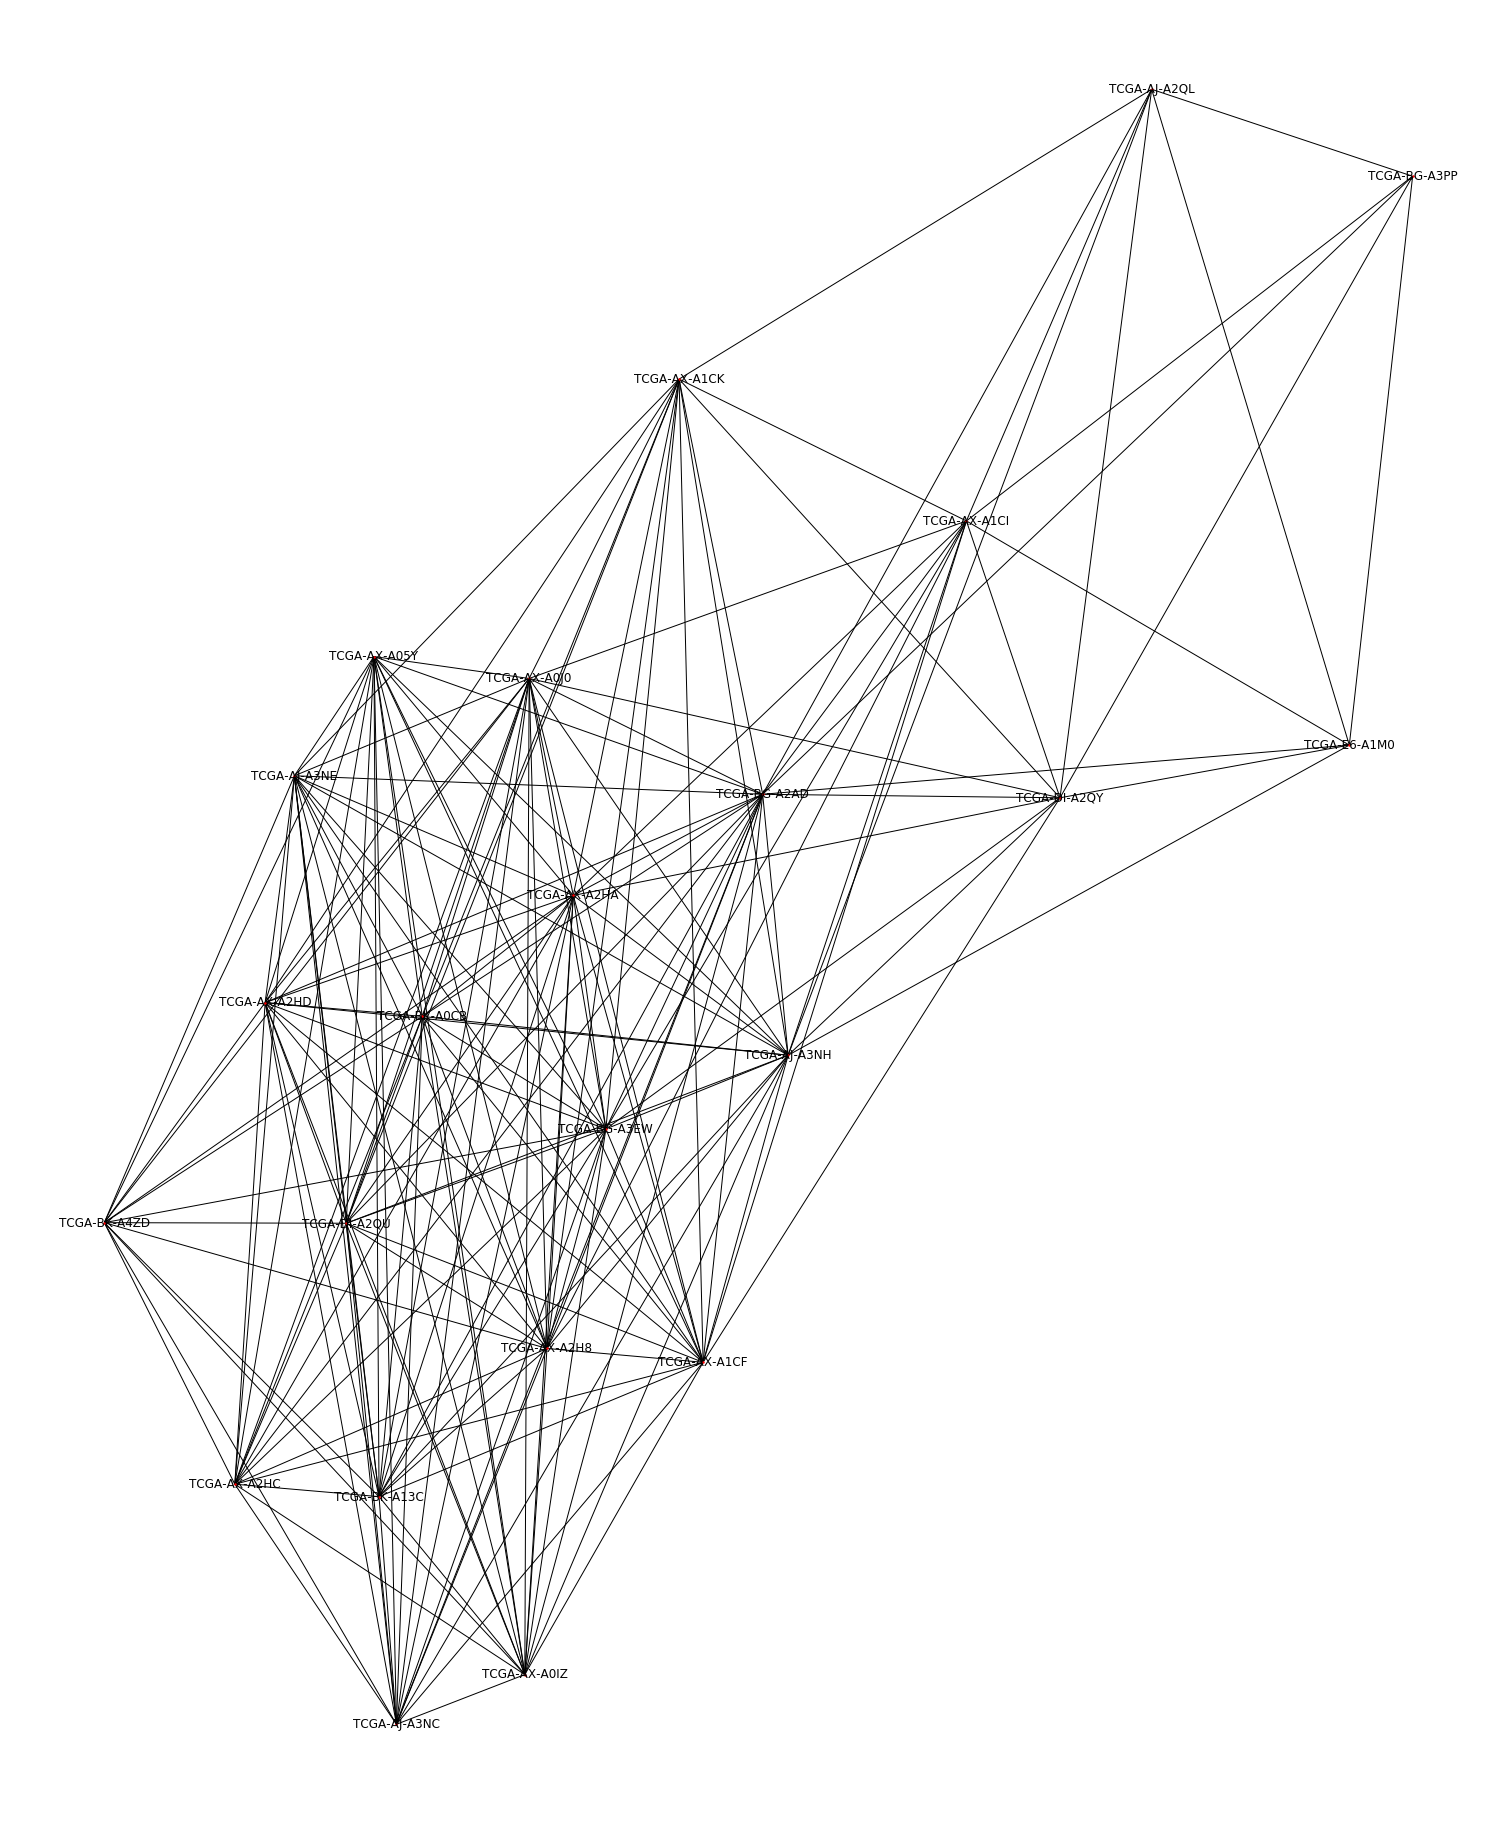

In [88]:
show_graph_with_labels(adj_matrix_N)

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


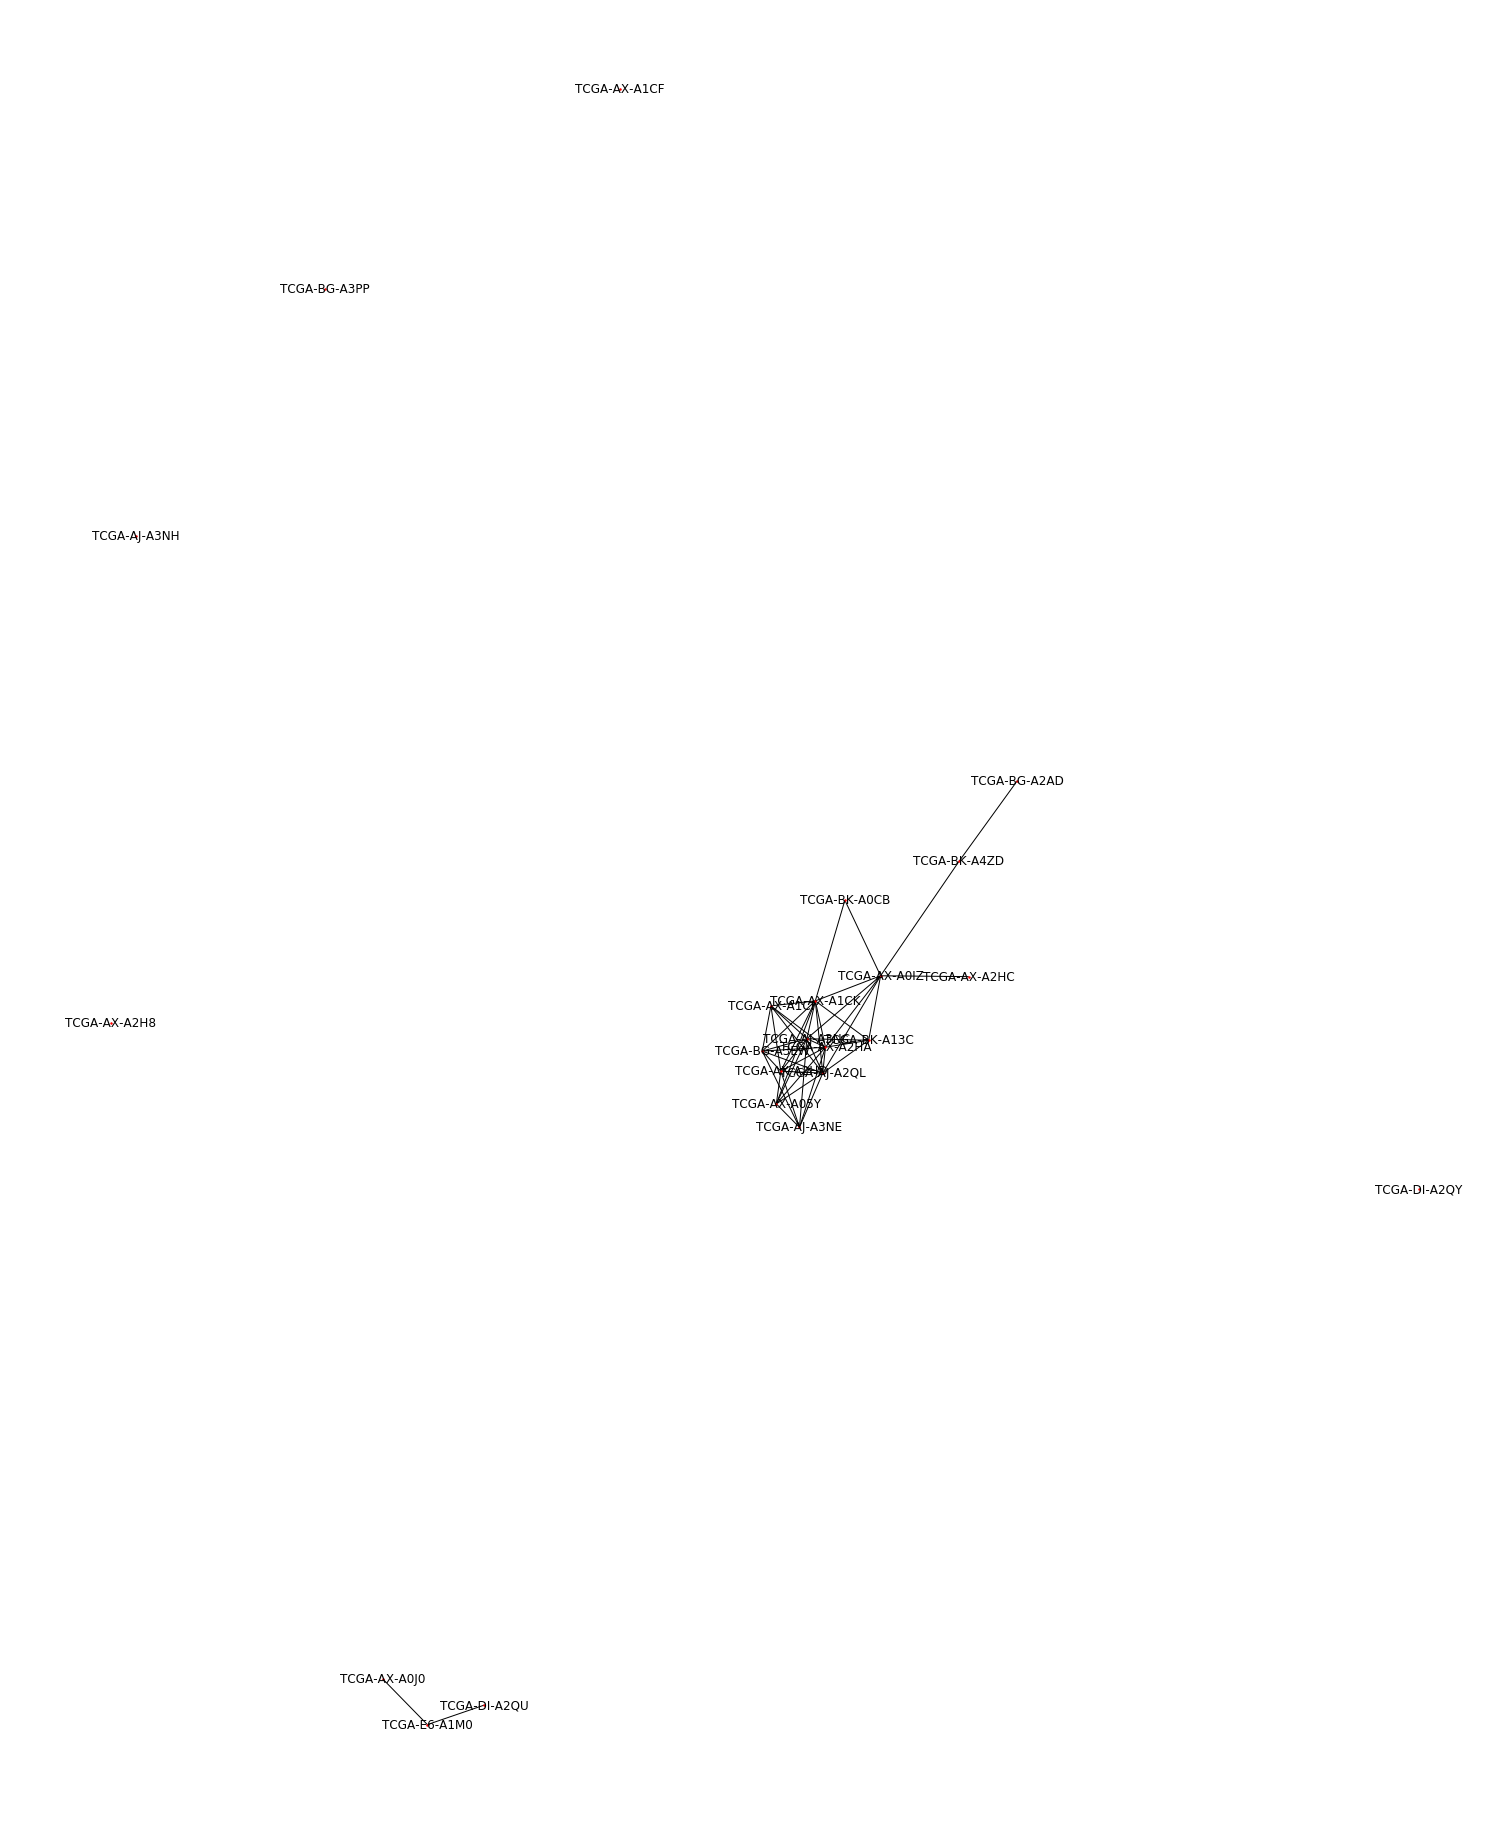

In [89]:
show_graph_with_labels(adj_matrix_C)

Banuska and Melis and check what I did before hahaa as I also should

4. Compute the degree index and find the hubs (5% of the nodes with highest degree values)
5. Compare hubs sets related to the two condition (cancer, normal) and identify the hubs characterizing only cancer tissue.